In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mutual_info_score 
from sklearn.model_selection import train_test_split
    
from model_wrapper import NBVariants

# Chapter 1: Data understanding and processing (EDA)

## 1.1 Get to know the data

In [2]:
path = "./HR_comma_sep.csv"
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [3]:
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


Th dataset contains information about employees who worked in a company. These information included:
- Satisfactory Level
- Number of Project
- Average Monthly Hours
- Time Spend Company
- Promotion Last 5 Years
- Department
- Salary

The information was obtained mainly to predict employees retention - choose to stay or leave the company - defined by the "left" column 

## 1.2 Data cleaning and preprocessing
Include handling with:
- Inconsistent in col names
- Missing values
- Duplicate values
- Identify target variable and features
- Features importance and engineering
- Outliers
- Validation framework
- Label encoding with One-hot

### inconsistent column names

In [4]:
# normailize cols name
df.columns = df.columns.str.lower()
print(list(df.columns))

['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'work_accident', 'left', 'promotion_last_5years', 'department', 'salary']


### missing values

In [5]:
# missing values
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

$\to$ Luckily, no missing values were found

### duplicate values

In [6]:
# duplicate values
dups = df.duplicated().sum()
print(dups/df.shape[0])

0.2005467031135409


$\to$ 20% of the data were found to be duplicates. In this particular case, we will remove all the duplicates to prevent skewed, as each instances in the data represent an employee, and each of them should be treated independently for the best prediction result.

In [7]:
# handle duplication
print(f"Before: {df.shape}")
df = df.drop_duplicates(keep='first')
print(f"After: {df.shape}")

Before: (14999, 10)
After: (11991, 10)


### obtain categorical and numerical features

In [8]:
# get categorical features
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical.extend(["work_accident", "promotion_last_5years"])

# get numerical features
numerical = list(df.drop(columns=categorical).columns)
numerical.remove("left")

print(categorical, numerical)

['department', 'salary', 'work_accident', 'promotion_last_5years'] ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']


- Target is: 'left'
- Categorical features include: 'department', 'salary', 'work_accident', 'promotion_last_5years'
- Numerical features include: 'satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company'

### feature importance and engineering

In [9]:
# explore categorical features with mutual info
for col in categorical:
    print(df[col].value_counts(), "\n")
    print(f"Mutual info between retention and {col}: {mutual_info_score(df.left, df[col])}", "\n")

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64 

Mutual info between retention and department: 0.0009237527382885066 

salary
low       5740
medium    5261
high       990
Name: count, dtype: int64 

Mutual info between retention and salary: 0.008497990094004336 

work_accident
0    10141
1     1850
Name: count, dtype: int64 

Mutual info between retention and work_accident: 0.00969738527197149 

promotion_last_5years
0    11788
1      203
Name: count, dtype: int64 

Mutual info between retention and promotion_last_5years: 0.001356175449427931 



$\to$ Based on the result of mutual information, it is likely that salary and work_accident are more of potential features to predict employee retention than the rest. Hence, we will include these in the models.

In [10]:
# explore numerical features with correlation matrix
df[numerical].corrwith(df.left)

satisfaction_level     -0.350558
last_evaluation         0.013520
number_project          0.030928
average_montly_hours    0.070409
time_spend_company      0.173295
dtype: float64

$\to$ The correlation matrix tells us that, only features like satisfaction_level, time_spend_company, and average_monthly_hours are likely affected employee retention. Hence, we will also include them in the models, and save the others for further investigation.

In [11]:
# features will be used in prediction
categorical = ["salary", "work_accident"]
numerical = ["satisfaction_level", "time_spend_company", "average_montly_hours"]

### outliers

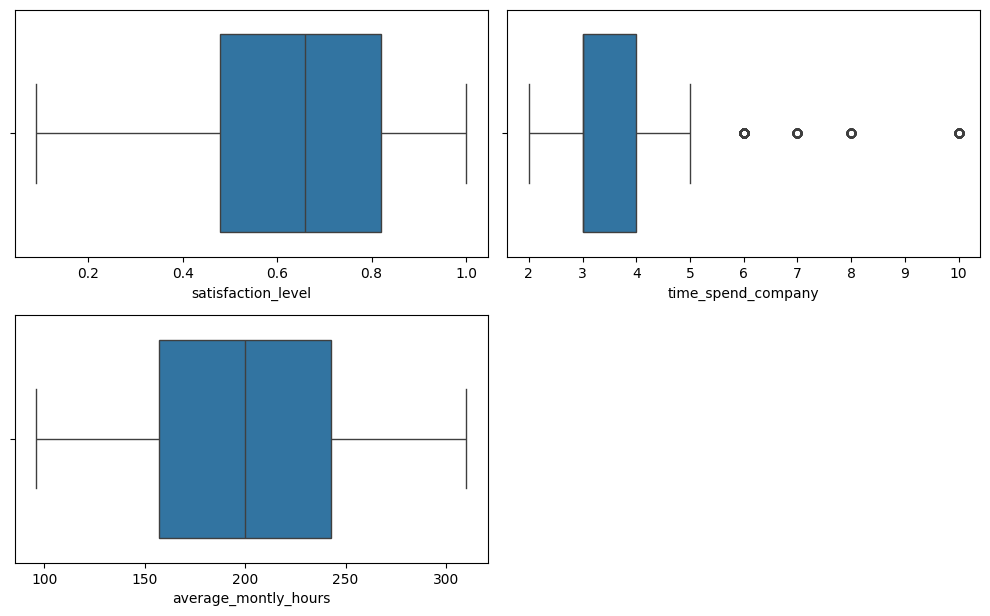

In [12]:
# detect outliers for numerical values
plt.figure(figsize=(10, 15))
for i, col in enumerate(numerical):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

$\to$ From the boxplots, we can observe that time_spend_company varible contains multiple outilers that need to be addressed. But before we can decide wheter or not to remove outliers, it is important to first investigate the reason behind the existence of these values. And since some models are more sensitive to outliers than other, it also depends on the type of models we choose.

### validation framework
Setting up a validation process includes:
- Train data (60%)
- Validation data (20%)
- Test data (20%)

In [13]:
# spliting data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
len(df_full_train), len(df_test)

(9592, 2399)

# Chapter 2: Model implementation

In [14]:
NB_models = NBVariants(df, target='left', numerical=numerical, categorical=categorical)

---Gaussian---
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      6195
           1       0.77      0.40      0.53      2798

    accuracy                           0.78      8993
   macro avg       0.77      0.67      0.69      8993
weighted avg       0.78      0.78      0.75      8993

---Multinomial---
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      8972
           1       0.00      0.24      0.01        21

    accuracy                           0.84      8993
   macro avg       0.50      0.54      0.46      8993
weighted avg       1.00      0.84      0.91      8993

---Bernoulli---
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.16      0.28      8993

    accuracy                           0.16      8993
   macro avg       0.50      0.58      0.14      8993
weighted avg       1.00  

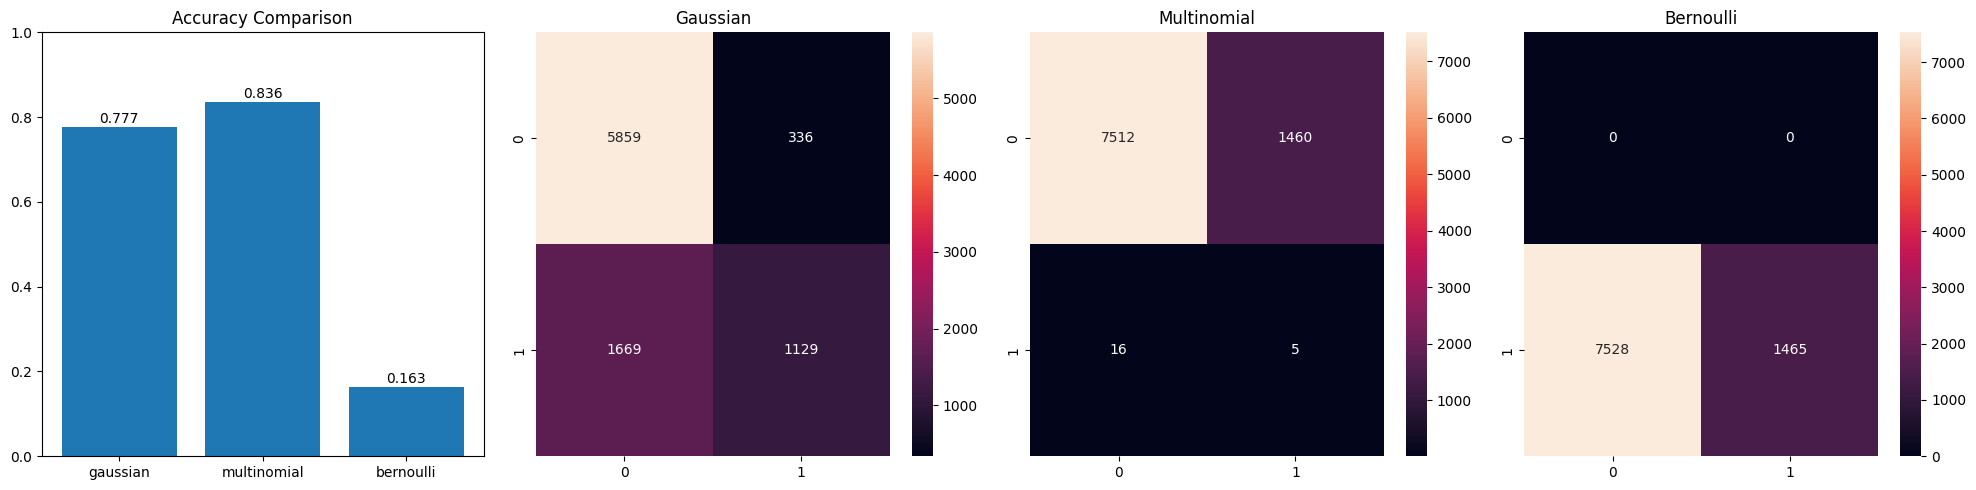

In [15]:
results = NB_models.train_models(test_size=0.25, random_state=1)
NB_models.compare(results)